## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Users\a0970\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [11]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.1,0.5]
redice_lr_patient = [5,10]

In [12]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

Epoch 13/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.6850 - acc: 0.4116 - val_loss: 1.7613 - val_acc: 0.3930
Epoch 14/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.6681 - acc: 0.4188 - val_loss: 1.7479 - val_acc: 0.3985
Epoch 15/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.6536 - acc: 0.4228 - val_loss: 1.7379 - val_acc: 0.3986
Epoch 16/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.6386 - acc: 0.4271 - val_loss: 1.7278 - val_acc: 0.4029
Epoch 17/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.6259 - acc: 0.4320 - val_loss: 1.7159 - val_acc: 0.4065
Epoch 18/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.6123 - acc: 0.4366 - val_loss: 1.7106 - val_acc: 0.4076
Epoch 19/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.6010 - acc: 0.4400 - val_loss: 1.6995 - val_acc: 0.4100
Epoch 20/25
50000/50000 [==

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 151us/step - loss: 2.6733 - acc: 0.1615 - val_loss: 2.6136 - val_acc: 0.2039
Epoch 2/25
50000/50000 [==============================] - 7s 134us/step - loss: 2.2300 - acc: 0.2619 - val_loss: 2.2494 - val_acc: 0.2698
Epoch 3/25
50000/50000 [==============================] - 7s 139us/step - loss: 2.0583 - acc: 0.3053 - val_loss: 2.0905 - val_acc: 0.3032
Epoch 4/25
50000/50000 [==============================] - 11s 220us/step - loss: 1.9632 - acc: 0.3317 - val_loss: 2.0055 - val_acc: 0.3273
Epoch 5/25
50000/50000 [==============================] - 11s 227us/step - loss: 1.8997 - acc: 0.3518 - val_loss: 1.9440 - val_acc: 0.3427
Epoch 6/25
50000/50000 [==============================] - 12s 233us/step - loss: 1.8505 - acc: 0.3654 - val_loss: 1.9001 - val_acc: 0.3514
Epoch 7/25
50000/50000 [==============================] - 13s 250us/step - loss: 1.8119 - acc: 0.3756 - val_loss: 1.868

50000/50000 [==============================] - 9s 180us/step - loss: 0.8125 - acc: 0.7304 - val_loss: 1.3024 - val_acc: 0.5469
Epoch 23/25
50000/50000 [==============================] - 10s 193us/step - loss: 0.8100 - acc: 0.7304 - val_loss: 1.3029 - val_acc: 0.5479
Epoch 24/25
50000/50000 [==============================] - 8s 164us/step - loss: 0.8090 - acc: 0.7311 - val_loss: 1.3035 - val_acc: 0.5459

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 25/25
50000/50000 [==============================] - 8s 159us/step - loss: 0.8052 - acc: 0.7325 - val_loss: 1.3035 - val_acc: 0.5465
Numbers of exp: 5, reduce_factor: 0.10, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)          

Epoch 9/25
50000/50000 [==============================] - 9s 171us/step - loss: 2.0643 - acc: 0.3017 - val_loss: 2.0958 - val_acc: 0.2930
Epoch 10/25
50000/50000 [==============================] - 8s 153us/step - loss: 2.0421 - acc: 0.3066 - val_loss: 2.0767 - val_acc: 0.2992
Epoch 11/25
50000/50000 [==============================] - 8s 151us/step - loss: 2.0228 - acc: 0.3135 - val_loss: 2.0605 - val_acc: 0.3042
Epoch 12/25
50000/50000 [==============================] - 7s 149us/step - loss: 2.0045 - acc: 0.3190 - val_loss: 2.0454 - val_acc: 0.3089
Epoch 13/25
50000/50000 [==============================] - 7s 148us/step - loss: 1.9891 - acc: 0.3242 - val_loss: 2.0309 - val_acc: 0.3100
Epoch 14/25
50000/50000 [==============================] - 7s 149us/step - loss: 1.9748 - acc: 0.3284 - val_loss: 2.0187 - val_acc: 0.3147
Epoch 15/25
50000/50000 [==============================] - 8s 155us/step - loss: 1.9614 - acc: 0.3312 - val_loss: 2.0067 - val_acc: 0.3177
Epoch 16/25
50000/50000 [===

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 10s 202us/step - loss: 1.7979 - acc: 0.3777 - val_loss: 2.3380 - val_acc: 0.2895
Epoch 2/25
50000/50000 [==============================] - 9s 182us/step - loss: 1.5357 - acc: 0.4590 - val_loss: 2.2958 - val_acc: 0.2907
Epoch 3/25
50000/50000 [==============================] - 9s 185us/step - loss: 1.4314 - acc: 0.4956 - val_loss: 2.0581 - val_acc: 0.3263
Epoch 4/25
50000/50000 [==============================] - 9s 186us/step - loss: 1.3575 - acc: 0.5209 - val_loss: 1.9776 - val_acc: 0.3172
Epoch 5/25
50000/50000 [==============================] - 9s 179us/step - loss: 1.3057 - acc: 0.5388 - val_loss: 2.0825 - val_acc: 0.3104
Epoch 6/25
50000/50000 [==============================] - 8s 161us/step - loss: 1.2547 - acc: 0.5567 - val_loss: 1.9302 - val_acc: 0.3454
Epoch 7/25
50000/50000 [==============================] - 8s 155us/step - loss: 1.2102 - acc: 0.5736 - val_loss: 1.7816 -

50000/50000 [==============================] - 14s 285us/step - loss: 1.4333 - acc: 0.5033 - val_loss: 1.6185 - val_acc: 0.4352
Epoch 23/25
50000/50000 [==============================] - 14s 282us/step - loss: 1.4218 - acc: 0.5069 - val_loss: 1.6114 - val_acc: 0.4383
Epoch 24/25
50000/50000 [==============================] - 14s 283us/step - loss: 1.4090 - acc: 0.5121 - val_loss: 1.6045 - val_acc: 0.4418
Epoch 25/25
50000/50000 [==============================] - 14s 282us/step - loss: 1.3975 - acc: 0.5160 - val_loss: 1.5995 - val_acc: 0.4414
Numbers of exp: 10, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_______________________________________________________________

50000/50000 [==============================] - 11s 229us/step - loss: 1.6792 - acc: 0.4171 - val_loss: 1.7615 - val_acc: 0.3927
Epoch 10/25
50000/50000 [==============================] - 9s 174us/step - loss: 1.6498 - acc: 0.4252 - val_loss: 1.7322 - val_acc: 0.3989
Epoch 11/25
50000/50000 [==============================] - 9s 175us/step - loss: 1.6246 - acc: 0.4346 - val_loss: 1.7174 - val_acc: 0.4057
Epoch 12/25
50000/50000 [==============================] - 9s 172us/step - loss: 1.6004 - acc: 0.4430 - val_loss: 1.7072 - val_acc: 0.4088
Epoch 13/25
50000/50000 [==============================] - 10s 191us/step - loss: 1.5794 - acc: 0.4492 - val_loss: 1.6837 - val_acc: 0.4153
Epoch 14/25
50000/50000 [==============================] - 9s 179us/step - loss: 1.5595 - acc: 0.4573 - val_loss: 1.6750 - val_acc: 0.4190
Epoch 15/25
50000/50000 [==============================] - 10s 191us/step - loss: 1.5403 - acc: 0.4644 - val_loss: 1.6586 - val_acc: 0.4174
Epoch 16/25
50000/50000 [===========

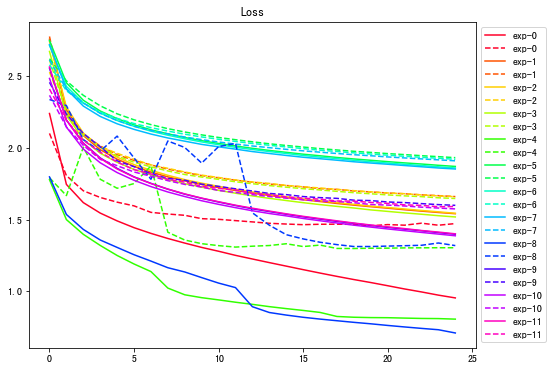

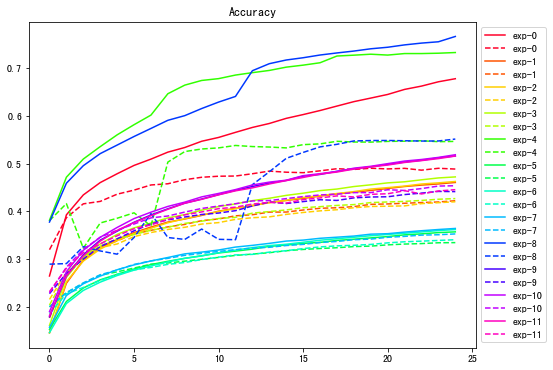

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()